# Time Series Analysis

Let's plot the data to see some patterns that might be helpful to know in advance, before starting to model the data.

## Import Libraries

In [1]:
# to add holidays features
import holidays

# Data visualisations
import matplotlib.pyplot as plt

# Base libraries
import numpy as np
import pandas as pd

# More data viz
import plotly.express as px
import seaborn as sns

# to use pandas dtypes in matplotlib plots
from pandas.plotting import register_matplotlib_converters

# rich
from rich.console import Console

# define rich console for formatted output
console = Console()

# have pandas types plotted with matplotlib
register_matplotlib_converters()

# set plotly as backend for plots wih pandas
pd.options.plotting.backend = "plotly"

# create a dict to update plotly layout
plotly_styles = dict(
    font_family="DejaVuSansMono Nerd Font",
    template="none",
    title={
        "x": 0.05,
        # basically, what part of the title to put at position "x"
        "xanchor": "left",
    },
)


# set settings for seaborn
sns.set_style(style="darkgrid", rc={"axes.facecolor": ".9", "grid.color": ".8"})
sns.set_palette(palette="deep")
sns_c = sns.color_palette(palette="deep")  # will be useful later

# visualise plots inline
%matplotlib inline

# customise matplotlib and sns plot dimensions
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 100

## Load Data and Preprocessing

In [13]:
daily_outflow = pd.read_csv("../data/bikemi_csv/daily_outflow.csv", parse_dates=[0])

daily_outflow = (
    daily_outflow.assign(
        year=lambda x: x["giorno_partenza"].dt.year,
        month=lambda x: x["giorno_partenza"].dt.month,
        month_name=lambda x: x["giorno_partenza"].dt.month_name().astype("category"),
        week=lambda x: x["giorno_partenza"].dt.isocalendar().week,
        day=lambda x: x["giorno_partenza"].dt.weekday,
        is_weekend=lambda x: x["day"].apply(lambda day: 1 if day in [5, 6] else 0),
        day_name=lambda x: x["giorno_partenza"].dt.day_name(),
        day_of_month=lambda x: x["giorno_partenza"].dt.day,
        day_of_year=lambda x: x["giorno_partenza"].dt.dayofyear,
        # alternatively:
        # holiday = lambda ts: list(map(lambda x: holidays.CountryHoliday("IT").get(x), ts["giorno_partenza"]))
        holiday=lambda ts: ts["giorno_partenza"].apply(
            lambda x: holidays.CountryHoliday("IT").get(x)
        ).replace(to_replace=np.NaN, value="No"),
    )
    .set_index("giorno_partenza")
    .astype({
        "is_weekend": "category",
        "day_name": "category",
        "holiday": "category",
    })
)

daily_outflow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   count         365 non-null    int64   
 1   year          365 non-null    int64   
 2   month         365 non-null    int64   
 3   month_name    365 non-null    category
 4   week          365 non-null    UInt32  
 5   day           365 non-null    int64   
 6   is_weekend    365 non-null    category
 7   day_name      365 non-null    category
 8   day_of_month  365 non-null    int64   
 9   day_of_year   365 non-null    int64   
 10  holiday       365 non-null    category
dtypes: UInt32(1), category(4), int64(6)
memory usage: 24.7 KB


Finally, let's see what our data looks like:

In [14]:
daily_outflow.head(10)

count  year  month month_name  week  day is_weekend  \
giorno_partenza                                                        
2019-01-01         831  2019      1    January     1    1          0   
2019-01-02        3512  2019      1    January     1    2          0   
2019-01-03        4126  2019      1    January     1    3          0   
2019-01-04        4201  2019      1    January     1    4          0   
2019-01-05        2875  2019      1    January     1    5          1   
2019-01-06        2878  2019      1    January     1    6          1   
2019-01-07        8662  2019      1    January     2    0          0   
2019-01-08        8948  2019      1    January     2    1          0   
2019-01-09        9205  2019      1    January     2    2          0   
2019-01-10        8703  2019      1    January     2    3          0   

                  day_name  day_of_month  day_of_year               holiday  
giorno_partenza                                                              
2019-01-01         Tuesday             1            1             Capodanno  
2019-01-02       Wednesday             2            2                    No  
2019-01-03        Thursday             3            3                    No  
2019-01-04          Friday             4            4                    No  
2019-01-05        Saturday             5            5                    No  
2019-01-06          Sunday             6            6  Epifania del Signore  
2019-01-07          Monday             7            7                    No  
2019-01-08         Tuesday             8            8                    No  
2019-01-09       Wednesday             9            9                    No  
2019-01-10        Thursday            10           10                    No

## Time Series Plot

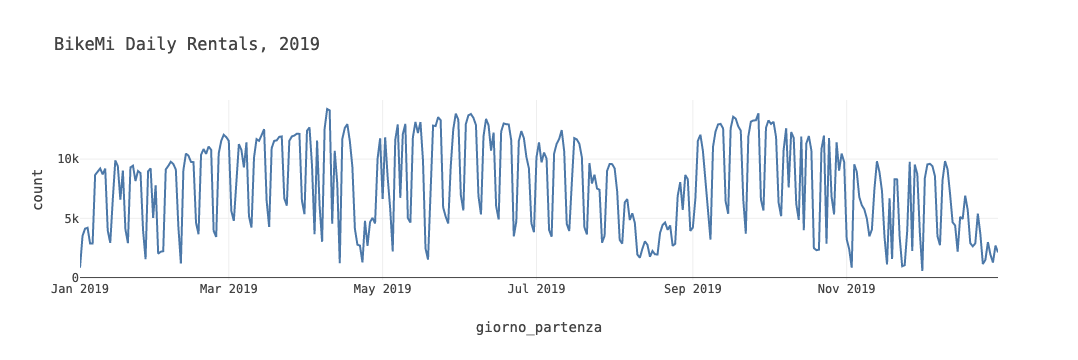

In [4]:
daily_outflow.plot(
    y="count",
    title="BikeMi Daily Rentals, 2019",
    color_discrete_sequence=px.colors.qualitative.T10,
).update_layout(**plotly_styles).update_traces(hovertemplate=None)

## Rolling Statistics

First, let's see how the mean and standard deviation change across time.

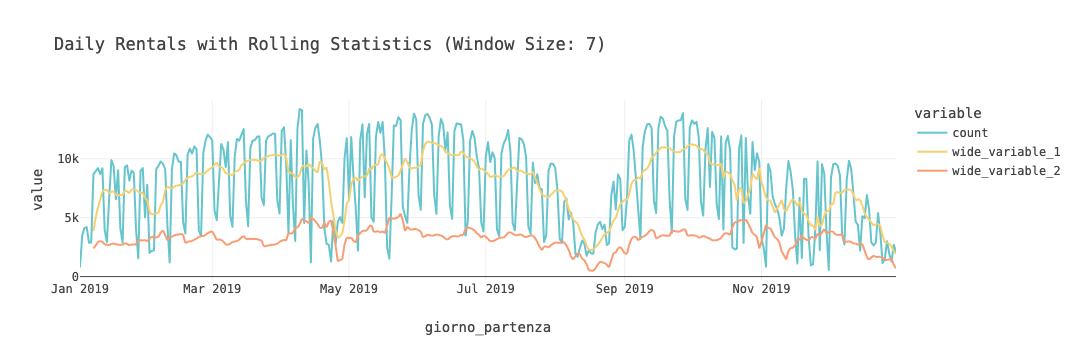

In [5]:
daily_outflow.plot(
    y=[
        "count",
        daily_outflow["count"].rolling(7).mean(),
        daily_outflow["count"].rolling(7).std(),
    ],
    title="Daily Rentals with Rolling Statistics (Window Size: 7)",
    color_discrete_sequence=px.colors.qualitative.Pastel,
).update_layout(**plotly_styles).update_traces(hovertemplate=None)

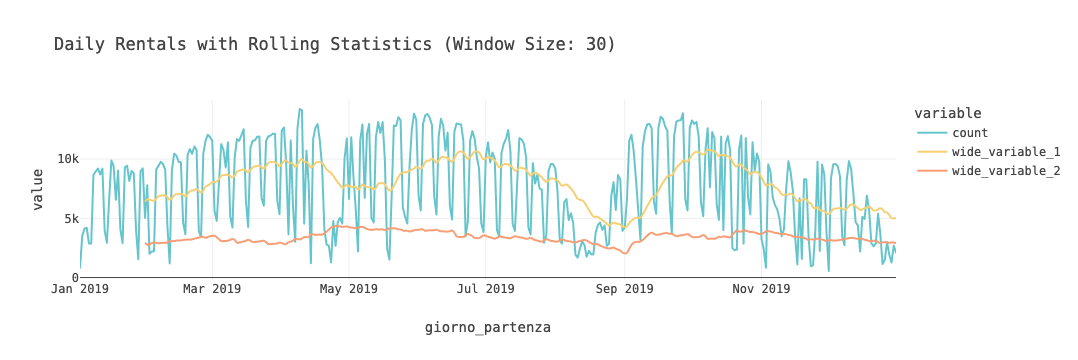

In [6]:
daily_outflow.plot(
    y=[
        "count",
        daily_outflow["count"].rolling(30).mean(),
        daily_outflow["count"].rolling(30).std(),
    ],
    title="Daily Rentals with Rolling Statistics (Window Size: 30)",
    color_discrete_sequence=px.colors.qualitative.Pastel,
).update_layout(**plotly_styles).update_traces(hovertemplate=None)

The most relevant thing about these statistics is that the seasonal component of the time series does not really smooth out even with a 30 days lag, suggesting a strong dependence even with past lags.

Given this distribution, we expect a strong relationship between data points that are seven lags from each other. More importantly, we expect that this variance will hinder the accuracy of our forecasts. This may require transforming the data (e.g. by taking logs or applying a Box-Cox transformation and searching for the optimal parameter $\lambda$) or *decomposing the time series*.

### Non-Interactive Plot

We can also make a pretty plot to export:

Text(0.5, 1.02, 'Bikemi Rentals (Daily) - Smooth Moving Average')

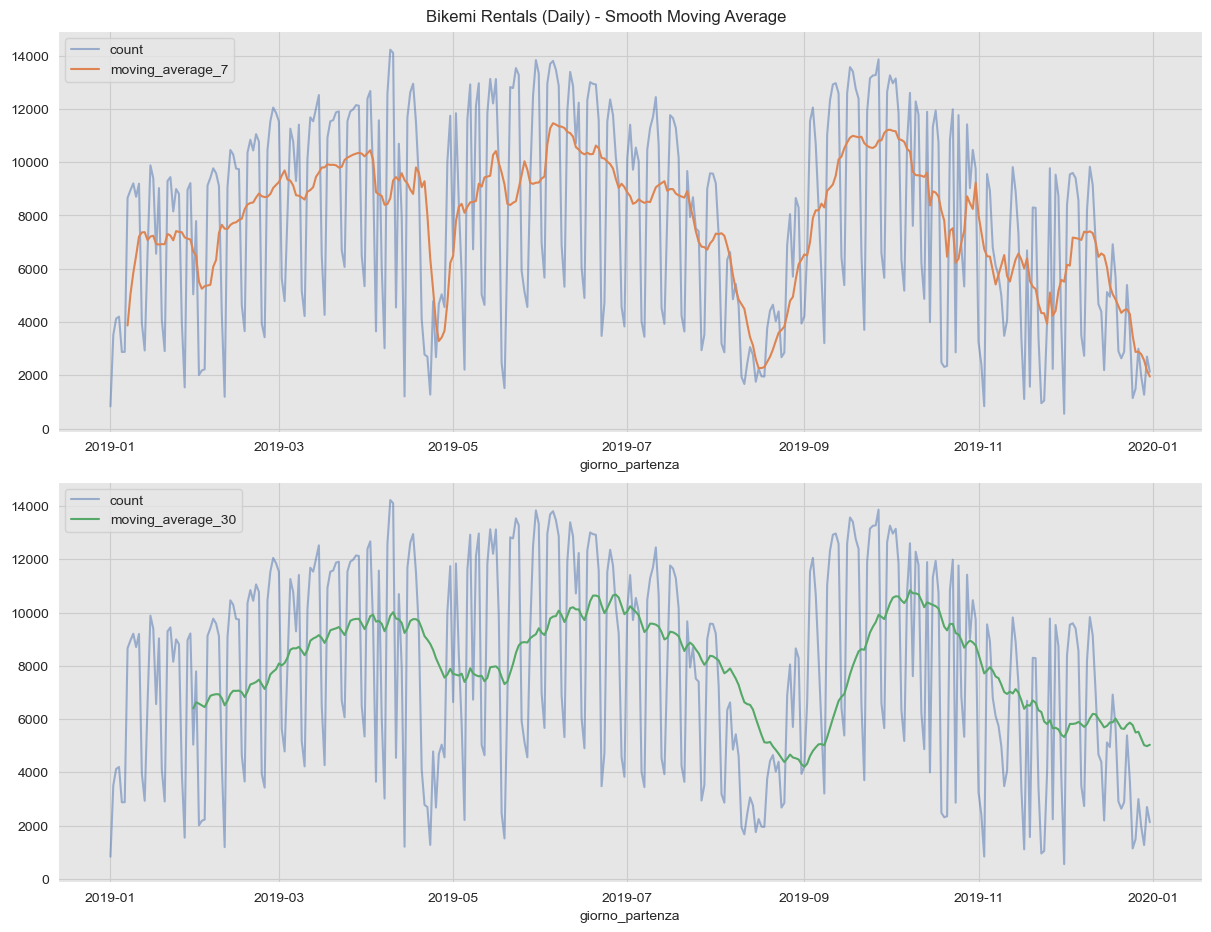

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(12, 9), constrained_layout=True)

# create the windows
ma = [7, 30]

for i, m in enumerate(ma):

    daily_outflow[f"moving_average_{m}"] = (
        daily_outflow["count"].rolling(window=m).mean()
    )

    sns.lineplot(
        x=daily_outflow.index,
        y="count",
        label="count",
        data=daily_outflow,
        alpha=0.5,
        ax=ax[i],
    )
    sns.lineplot(
        x=daily_outflow.index,
        y=f"moving_average_{m}",
        label=f"moving_average_{m}",
        data=daily_outflow,
        color=sns_c[i + 1],
        ax=ax[i],
    )
    ax[i].legend(loc="upper left")
    ax[i].set(title="", ylabel="")

plt.suptitle("Bikemi Rentals (Daily) - Smooth Moving Average", y=1.02)

## Histograms

Then, we look for patterns. First, let's see what changes across weekends and during holidays.

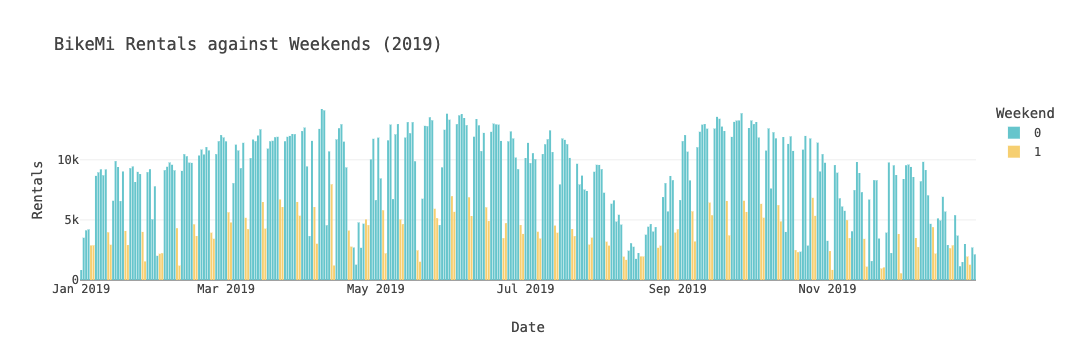

In [5]:
daily_outflow.plot.bar(
    x=daily_outflow.index,
    y="count",
    title="BikeMi Rentals against Weekends (2019)",
    color="is_weekend",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    labels={"count": "Rentals ", "giorno_partenza": "Date ", "is_weekend": "Weekend "},
).update_layout(**plotly_styles)

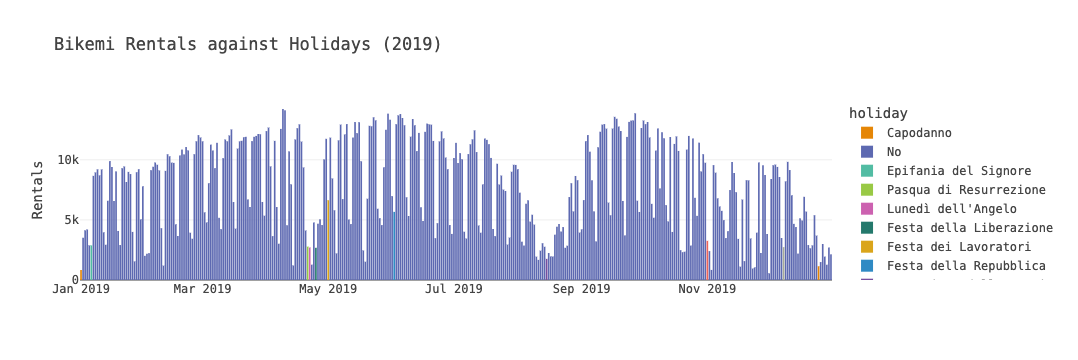

In [15]:
(
    daily_outflow.plot.bar(
        x=daily_outflow.index,
        y="count",
        title="Bikemi Rentals against Holidays (2019)",
        color="holiday",
        color_discrete_sequence=px.colors.qualitative.Vivid,
        labels={"count": "Rentals ", "giorno_partenza": ""},
    )
    .update_layout(**plotly_styles)
    .update_traces(hovertemplate=None)
)

## Other Kinds of Seasonalities: Monthly and Daily Data Distributions

Let's have a closer look at seasonal patterns. We import some custom functions we developed to plot these special patterns:

### Seasonal Plots

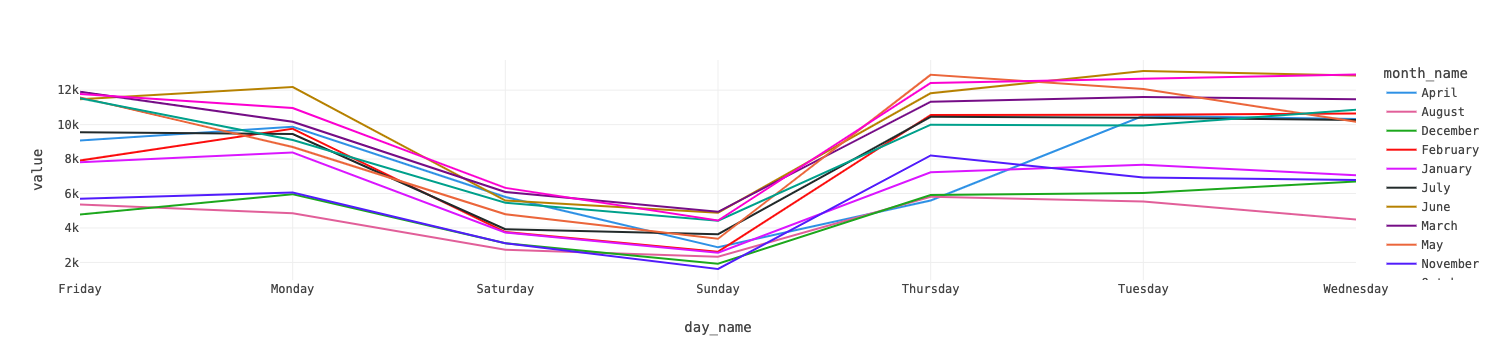

In [29]:
# play with color palettes: https://plotly.com/python/discrete-color/
(
    pd.pivot_table(
        data=daily_outflow[["day_name", "month_name", "count"]],
        index="day_name",
        columns="month_name",
    )["count"]
    .plot(color_discrete_sequence=px.colors.qualitative.Dark24)
    .update_layout(**plotly_styles)
    .update_traces(hovertemplate=None)
)

Looking at the series' plot, it seems clear that the most important source of variation clearly is the weekly seasonality. The boxplot function is designed to accept various time formats, so we can adapt it pretty quickly:

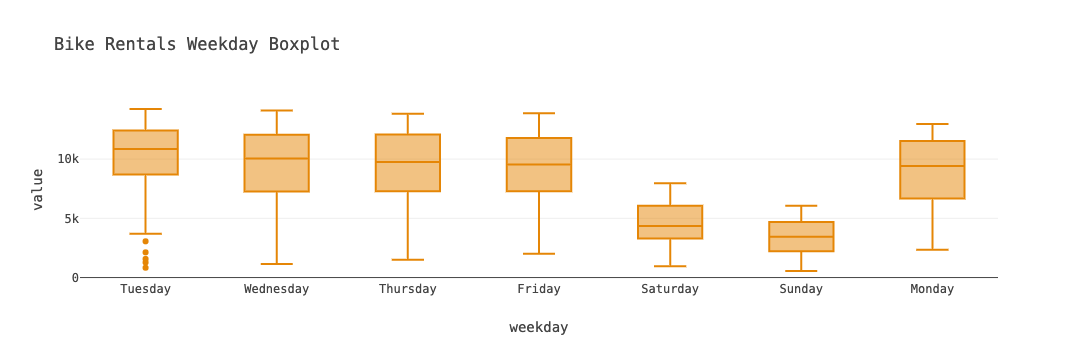

In [18]:
subunits_boxplot(daily_outflow["count"], y="count", time_subunit="weekday")

Note: the plot starts on Tuesday because the data starts on Tuesday and the categorical variable is coded with its first level to be that day.

## Appendix: Functions for Rolling Statistics

The following function work with matplotlib (plt)

In [23]:
from custom_functions.time_series_analysis import plt_rolling_statistics, px_rolling_statistics

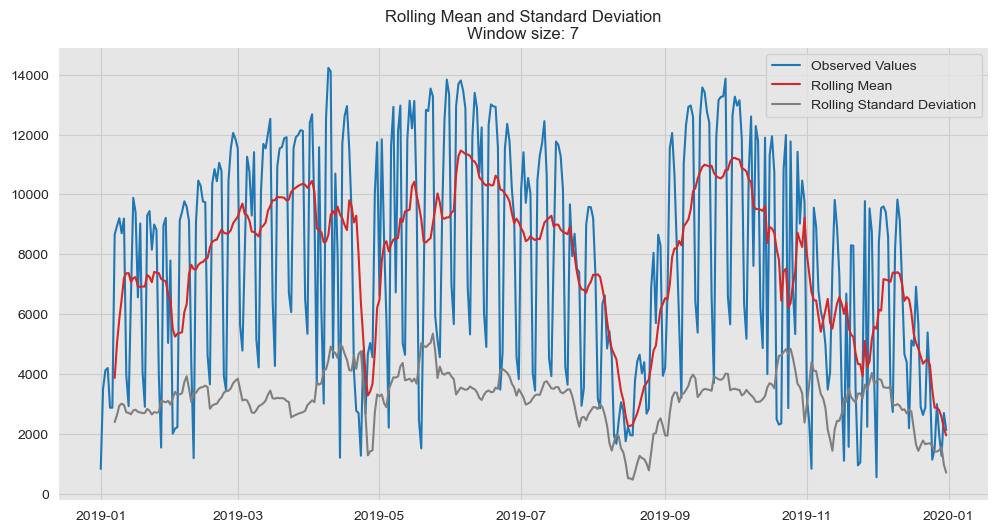

In [21]:
plt_rolling_statistics(
    ts=daily_outflow["count"], lags=7, statistics=["mean", "std"]
)

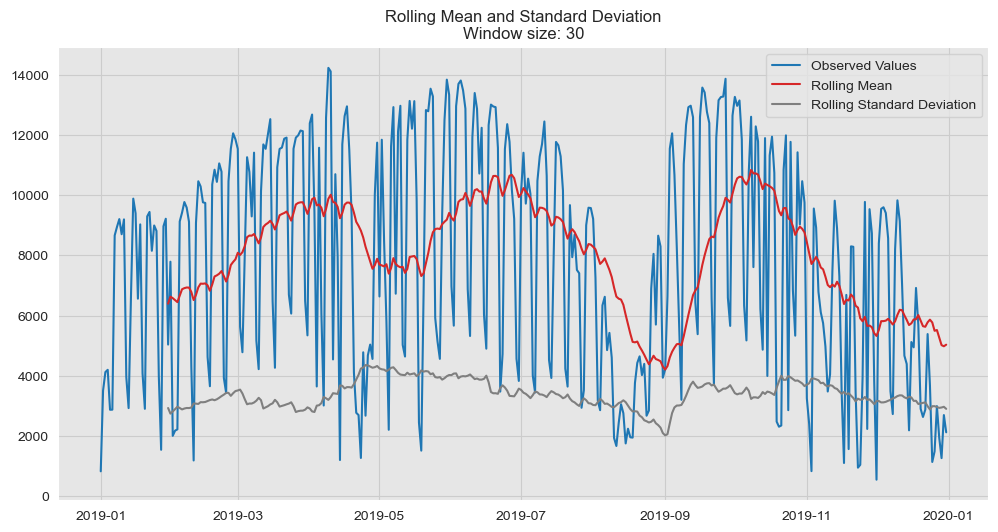

In [25]:
plt_rolling_statistics(
    ts=daily_outflow["count"], lags=30, statistics=["mean", "std"]
)

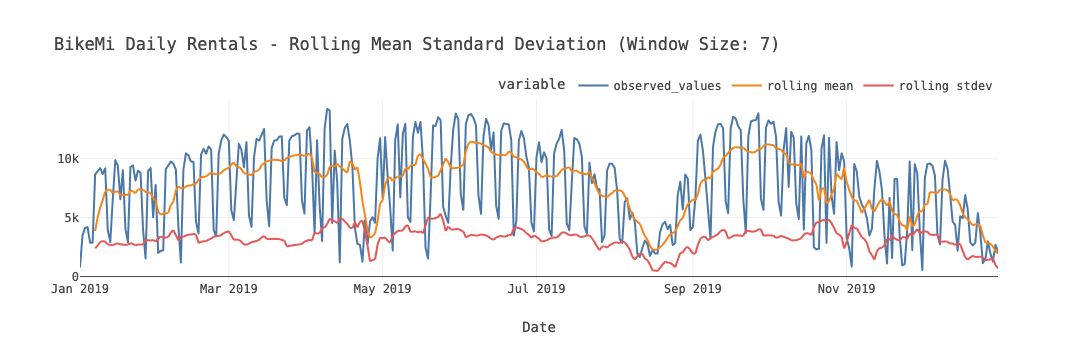

In [28]:
px_rolling_statistics(
    ts=daily_outflow, col="count", lags=7, statistics=["mean", "std"]
)

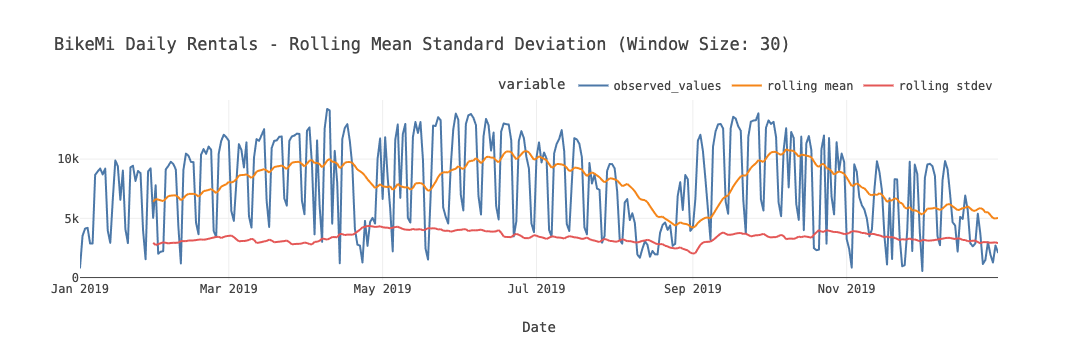

In [27]:
px_rolling_statistics(
    ts=daily_outflow, col="count", lags=30, statistics=["mean", "std"]
)